<a href="https://colab.research.google.com/github/aivrm/ai/blob/main/EX_4_STEP_7_%EB%8B%A4%EB%A5%B8_%EC%A3%BC%EC%8B%9D_%EC%A2%85%EB%AA%A9_%EC%98%88%EC%B8%A1%ED%95%B4_%EB%B3%B4%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
# LG디스플레이

LG Display Co., Ltd. (LPL)

https://finance.yahoo.com/quote/LPL/history?p=LPL

---

In [41]:
#import os
from os.path import join

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
import statsmodels

'''
import warnings
warnings.filterwarnings('ignore')
'''

print(pd.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.3.5
1.0.2
0.13.0


---
### STEP 1: 시계열 데이터 읽기

---

In [43]:
DATA_DIR = '/content/drive/MyDrive/_aiffel/aiffel/stock_prediction/data'
csv_path = join(DATA_DIR, 'LPL.csv')

In [44]:
# Time Series 생성
df = pd.read_csv(csv_path, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-07-29    9.80
2021-07-30    9.53
2021-08-02    9.52
2021-08-03    9.67
2021-08-04    9.85
Name: Close, dtype: float64

---
### STEP 2 : 전처리

---

In [45]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [46]:
# 로그 변환
ts_log = np.log(ts)

---
### STEP 3 : 시계열 안정성 분석

---

In [47]:
# 이동평균
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [48]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

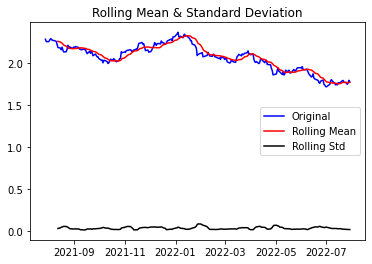

Results of Dickey-Fuller Test:
Test Statistic                  -0.903943
p-value                          0.786671
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


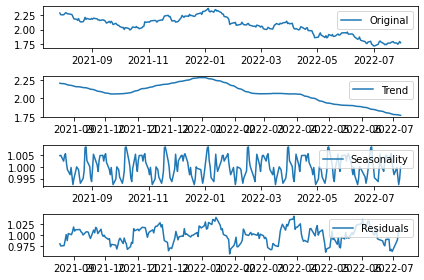

In [49]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
# [[YOUR CODE]]
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [50]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.229182
p-value                          0.000008
#Lags Used                       7.000000
Number of Observations Used    215.000000
Critical Value (1%)             -3.461136
Critical Value (5%)             -2.875079
Critical Value (10%)            -2.573986
dtype: float64


---
### STEP 4 : 학습, 테스트 데이터셋 생성

---

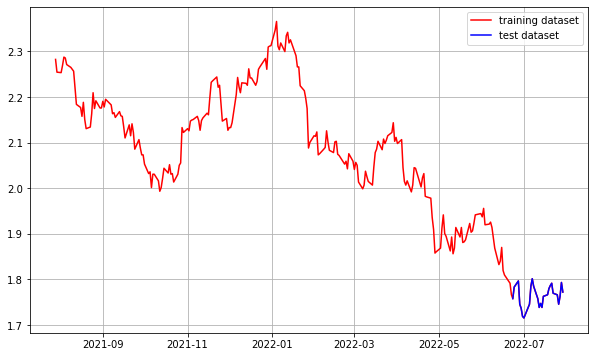

In [51]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

---
### STEP 5 : 적정 ARIMA 모수 찾기

* ACF, PACF 그려보기 -> p,q 구하기
* 차분 안정성 확인 -> d 구하기

---

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


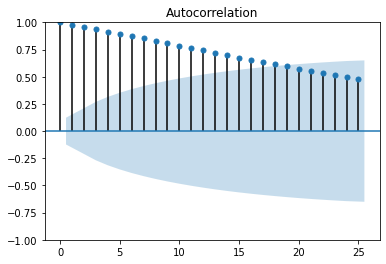

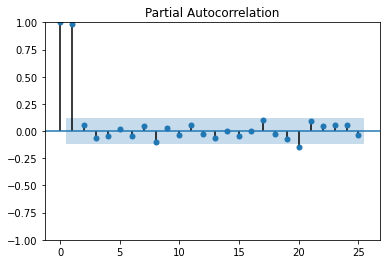

In [52]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.623113e+01
p-value                        3.810617e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.781833e+00
p-value                        8.377394e-12
#Lags Used                     1.300000e+01
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


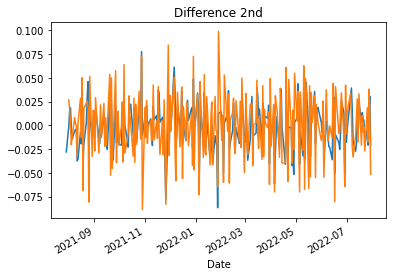

In [53]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

---
### STEP 6 : ARIMA 모델 훈련과 테스트

* ARIMA 모델 빌드와 훈련
* 모델 테스트 및 플로팅
* 최종 예측 모델 정확도 측정(MAPE)

---

In [54]:
# Build and Train  Model
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 520.314
Date:                Fri, 29 Jul 2022   AIC                          -1030.628
Time:                        16:00:49   BIC                          -1013.503
Sample:                             0   HQIC                         -1023.718
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0524      0.205     10.010      0.000       1.651       2.454
ar.L1          0.1144      0.115      0.994      0.320      -0.111       0.340
ar.L2          0.8759      0.116      7.546      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


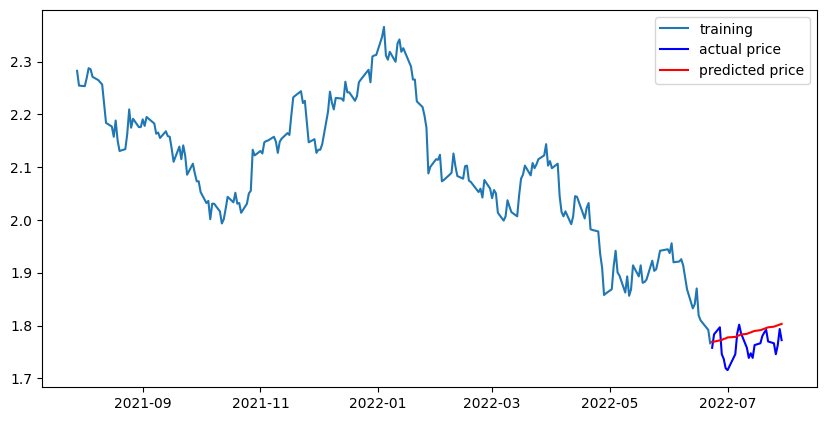

In [55]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  0.03561476388851022
MAE:  0.16216010264289074
RMSE:  0.1887187428119163
MAPE: 2.81%


---
## 회고

---

```
STEP 1~6 는 '삼성전자'를 대상으로 하였고,
STEP 7 에서는 'LG디스플레이'를 대상으로 실행하였습니다.
 다운 받은 파일명은 LPL.csv 이었습니다.
```

* 실행시 이번에는 seasonal_decompose 의 period 파라미터 부분에서 에러 발생

```
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<ipython-input-11-c17f13c629ac> in <module>()
      7 #시계열 분해 (Time Series Decomposition)
      8 from statsmodels.tsa.seasonal import seasonal_decompose
----> 9 decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)
     10 # [[YOUR CODE]]
     11 trend = decomposition.trend

TypeError: seasonal_decompose() got an unexpected keyword argument 'period'

```

이전에 statsmodels 다시 설치하였으나, 새 노트북 파일을 생성하니, 에러 발생.<br>
다시 버전 체크 해보니, 다시 원래의 옛날 버전이었습니다.

```
! pip list | grep statsmodels   을 해보니,

statsmodels                   0.10.2

로 동일한 문제 발생.

```

LMS 와 동일하게, 0.13.0 버전으로 statsmodels 를 설치합니다.

In [57]:
# pip install statsmodels==0.13.0

```
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Collecting statsmodels==0.13.0
  Downloading statsmodels-0.13.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.8 MB)
     |████████████████████████████████| 9.8 MB 7.5 MB/s 
Requirement already satisfied: patsy>=0.5.2 in /usr/local/lib/python3.7/dist-packages (from statsmodels==0.13.0) (0.5.2)
Requirement already satisfied: numpy>=1.17 in /usr/local/lib/python3.7/dist-packages (from statsmodels==0.13.0) (1.21.6)
Requirement already satisfied: pandas>=0.25 in /usr/local/lib/python3.7/dist-packages (from statsmodels==0.13.0) (1.3.5)
Requirement already satisfied: scipy>=1.3 in /usr/local/lib/python3.7/dist-packages (from statsmodels==0.13.0) (1.7.3)
Requirement already satisfied: python-dateutil>=2.7.3 in /usr/local/lib/python3.7/dist-packages (from pandas>=0.25->statsmodels==0.13.0) (2.8.2)
Requirement already satisfied: pytz>=2017.3 in /usr/local/lib/python3.7/dist-packages (from pandas>=0.25->statsmodels==0.13.0) (2022.1)
Requirement already satisfied: six in /usr/local/lib/python3.7/dist-packages (from patsy>=0.5.2->statsmodels==0.13.0) (1.15.0)
Installing collected packages: statsmodels
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
Successfully installed statsmodels-0.13.0
WARNING: The following packages were previously imported in this runtime:
  [statsmodels]
You must restart the runtime in order to use newly installed versions.
```

statsmodels 를 LMS 와 동일하게, 0.13.0 버전으로 설치하니, 이상없었습니다.

---

LG디스플레이는 21/07/29 ~ 22/07/29 까지 1년치 데이터 였습니다.

전반적으로 주가가 하락하고 있군요.

그런데, 최근 7월 한달간을 보면,

예측치 보다 더 하락하면,

예측치까지 오르고 하락하는 모습이 관찰됩니다.

마치 어디까지 오를 수 있다고, 정확히 예측 성공한 모습 같아 보입니다.